In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from sklearn.metrics import mean_squared_error

from math import log
from numpy import random
from datetime import date

#### This cell reads in the train/test scores and CV results of all the models. CV is done using sklearn's GridSearchCV()

In [4]:
path = Path.cwd()
path = path.joinpath('Models')

modelPaths = list(path.glob('*'))

testResults = pd.DataFrame()
CVResults = pd.DataFrame()
regressorCoeffs = pd.DataFrame()
CFGS = {}
for modelPath in modelPaths:
    folder = modelPath.stem
    components = modelPath.stem.split('_')

    if len(components)==3:
        regressor = components[0]
        estimator = components[1]
        ts = components[2]

        testPath = modelPath.joinpath('testResults.csv')
        testResult = pd.read_csv(str(testPath))
        testResult['architecture'] = regressor+estimator
        testResult['ts'] = ts
        testResult['folder'] = folder

        CVPath = modelPath.joinpath('CV.csv')
        CVResult = pd.read_csv(str(CVPath))
        CVResult['architecture'] = regressor+estimator
        CVResult['ts'] = ts
        CVResult['folder'] = folder
        
        regressorCoeffPath = modelPath.joinpath('regressorCoeff.csv')
        
        if regressorCoeffPath.exists():
            regressorCoeff = pd.read_csv(str(regressorCoeffPath))
            regressorCoeff['architecture'] = regressor+estimator
            regressorCoeff['ts'] = ts
            regressorCoeff['folder'] = folder
            if len(regressorCoeffs)==0:
                regressorCoeffs=regressorCoeff.copy()
            else:
                regressorCoeffs=pd.concat([regressorCoeffs,regressorCoeff])
                
        CFGPath = modelPath.joinpath('CFG.txt')
        CFG = {}
        with CFGPath.open() as f:
            CFG = json.loads(f.read())
        CFGS[folder] = CFG

        if len(testResults)==0:
            testResults = testResult.copy()
            CVResults = CVResult.copy()
        else:
            testResults = pd.concat([testResults, testResult])
            CVResults = pd.concat([CVResults, CVResult])
        
        data = []
        for folder in testResults['folder'].unique():
            testResult = testResults[testResults['folder']==folder]
            ts = testResult['ts'].max()
            for alpha in testResult['alpha_value'].unique():
                alphaTestResult = testResult[testResult['alpha_value'] == alpha]
                alphaTestMSE = mean_squared_error(alphaTestResult['true'], alphaTestResult['predict'])
                alphaTrainMSE = alphaTestResult['trainScore'].max()
                data.append([folder, ts, alpha, alphaTestMSE, alphaTrainMSE])

        summary = pd.DataFrame(data=data, columns=['folder', 'ts', 'alpha', 'test', 'train'])
        
        summary['linear_regressor'] = summary['folder'].apply(lambda x:x.split('_')[0])
        summary['ensemble'] = summary['folder'].apply(lambda x:x.split('_')[1])

#### After I check different combinations of linear regressors and ensembles. It looks like GradientBoosting when used with Lasso has the best performance. We're overfitting, but we can try to correct for that by fine tuning our hyper parameters

In [14]:
view = summary[(summary['ts']>'202209190000') & (summary['ts']<'202209210000') & (summary['alpha']==1)]
view.sort_values('ts')

,folder,ts,alpha,test,train,linear_regressor,ensemble
129,Ridge_ExtraTreesRegressor_202209190849,202209190849,1,0.060432,0.050325,Ridge,ExtraTreesRegressor
2,Lasso_ExtraTreesRegressor_202209190850,202209190850,1,0.056068,0.047247,Lasso,ExtraTreesRegressor
0,ElasticNet_ExtraTreesRegressor_202209190852,202209190852,1,0.058445,0.048445,ElasticNet,ExtraTreesRegressor
1,HuberRegressor_ExtraTreesRegressor_202209190853,202209190853,1,0.059433,0.049227,HuberRegressor,ExtraTreesRegressor
128,Lasso_RandomForestRegressor_202209190926,202209190926,1,0.047937,0.031507,Lasso,RandomForestRegressor
3,Lasso_GradientBoostingRegressor_202209190929,202209190929,1,0.030353,0.004526,Lasso,GradientBoostingRegressor
127,Lasso_HistGradientBoostingRegressor_202209190931,202209190931,1,0.030047,0.016506,Lasso,HistGradientBoostingRegressor
5,Lasso_GradientBoostingRegressor_202209191304,202209191304,1,0.030191,0.004235,Lasso,GradientBoostingRegressor


In [23]:
view = summary[(summary['linear_regressor'] == 'Lasso') & (summary['ensemble'] == 'GradientBoostingRegressor')]

#### Next I'll find the best value of alpha for Lasso. It looks like whatever value I choose doesn't impact the model performance that much

<AxesSubplot:xlabel='alpha', ylabel='value'>

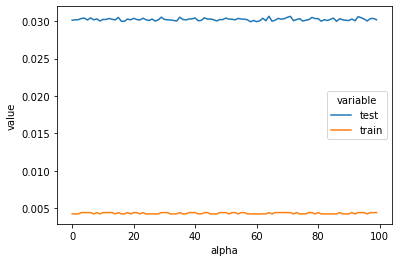

In [23]:
toPlot = view[view['ts']=='202209191304']
toPlot = toPlot[['alpha','test', 'train']]
sns.lineplot(x='alpha', y='value', hue='variable', data=pd.melt(toPlot, ['alpha']))

#### Below are visualizations of the train/test scores as a function of each hyperparameter

<AxesSubplot:xlabel='param_max_depth', ylabel='value'>

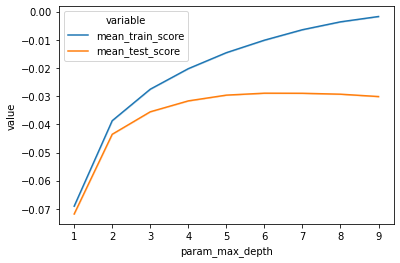

In [11]:
toPlot = CVResults[CVResults['ts']=='202209191512']
toPlot = toPlot[['param_max_depth','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_max_depth', y='value', hue='variable', data=pd.melt(toPlot, ['param_max_depth']))

<AxesSubplot:xlabel='param_min_samples_split', ylabel='value'>

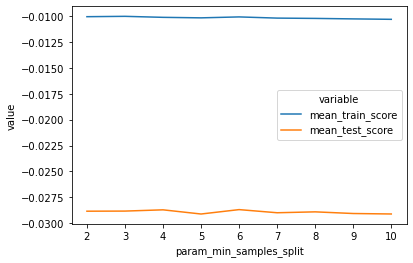

In [15]:
toPlot = CVResults[(CVResults['ts']=='202209191512') & (CVResults['param_max_depth']==6)]
toPlot = toPlot[['param_min_samples_split','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_min_samples_split', y='value', hue='variable', data=pd.melt(toPlot, ['param_min_samples_split']))

<AxesSubplot:xlabel='param_n_estimators', ylabel='value'>

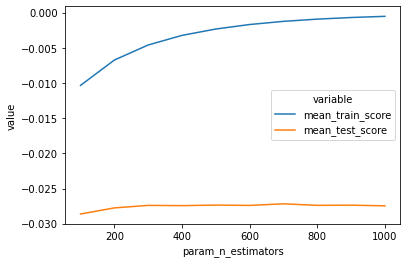

In [46]:
toPlot = CVResults[CVResults['ts']=='202209191723']
toPlot = toPlot[['param_n_estimators','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_n_estimators', y='value', hue='variable', data=pd.melt(toPlot, ['param_n_estimators']))

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='value'>

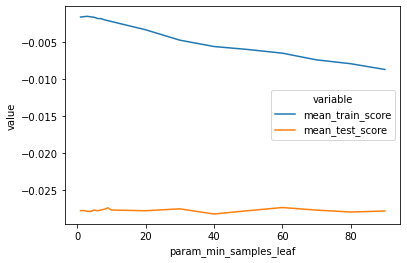

In [49]:
toPlot = CVResults[(CVResults['ts']=='202209191906') | (CVResults['ts']=='202209192029')]
toPlot = toPlot[['param_min_samples_leaf','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_min_samples_leaf', y='value', hue='variable', data=pd.melt(toPlot, ['param_min_samples_leaf']))

<AxesSubplot:xlabel='param_max_leaf_nodes', ylabel='value'>

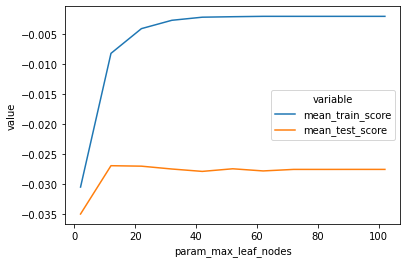

In [50]:
toPlot = CVResults[CVResults['ts']=='202209201115']
toPlot = toPlot[['param_max_leaf_nodes','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_max_leaf_nodes', y='value', hue='variable', data=pd.melt(toPlot, ['param_max_leaf_nodes']))

<AxesSubplot:xlabel='param_min_impurity_decrease', ylabel='value'>

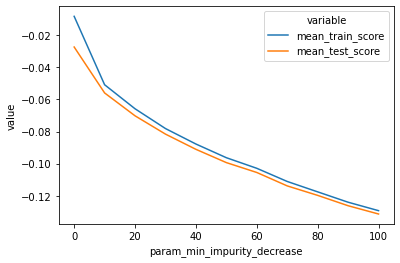

In [51]:
toPlot = CVResults[CVResults['ts']=='202209201216']
toPlot = toPlot[['param_min_impurity_decrease','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_min_impurity_decrease', y='value', hue='variable', data=pd.melt(toPlot, ['param_min_impurity_decrease']))

<AxesSubplot:xlabel='param_min_weight_fraction_leaf', ylabel='value'>

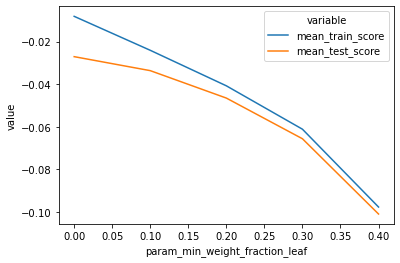

In [52]:
toPlot = CVResults[CVResults['ts']=='202209201241']
toPlot = toPlot[['param_min_weight_fraction_leaf','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_min_weight_fraction_leaf', y='value', hue='variable', data=pd.melt(toPlot, ['param_min_weight_fraction_leaf']))

<AxesSubplot:xlabel='param_max_features', ylabel='value'>

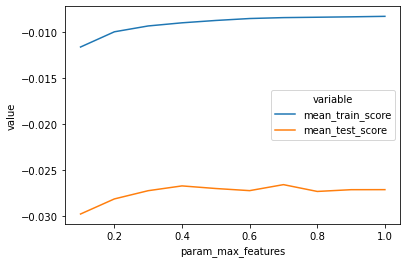

In [53]:
toPlot = CVResults[CVResults['ts']=='202209201319']
toPlot = toPlot[['param_max_features','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_max_features', y='value', hue='variable', data=pd.melt(toPlot, ['param_max_features']))

<AxesSubplot:xlabel='param_ccp_alpha', ylabel='value'>

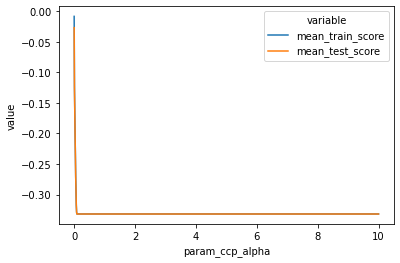

In [54]:
toPlot = CVResults[(CVResults['ts']=='202209201607') | (CVResults['ts']=='202209201800') | (CVResults['ts']=='202209201952')]
toPlot = toPlot[['param_ccp_alpha','mean_train_score', 'mean_test_score']]
sns.lineplot(x='param_ccp_alpha', y='value', hue='variable', data=pd.melt(toPlot, ['param_ccp_alpha']))